# 분석 목적
* 중장년층은 젊은 세대와는 다른 투자목적, 투자경험으로 인해 차별화된 사업전략이 필요할 수 있다.
* 나이대별 미국 주식 및 ETF 투자 동향을 데이터를 통해 분석하여, 각 연령층의 투자 성향과 선호도를 파악하고자 한다.
* 이를 바탕으로 미국 주식 및 ETF 투자의 참여를 촉진 할 수 있는 중장년층 맞춤형 서비스를 제공하고자 한다.



---------------------------------------------------------------------------------------------------------------------

# 분석 방법
1. **나이대별 인당 미국 주식 및 etf  보유 비율**
- oo데이터_고객보유정보에서 ‘고객 구성 대분류코드’값이 2(연령대)인 데이터만 추출
- oo데이터_주식일별정보 에서 종목별로 ‘총보유계좌수’와 NH데이터_고객보유정보에서 ‘고객구성계좌수비율’을 곱한 후, 종목의 개수로 나누게 되면 ‘종목별 평균 나이대별 보유 계좌 수’ 가 도출된다.
- 절대적인 인구 수를 고려해야하기 때문에 통계청에서 발표한 각 나이대의 인구수를 나눠주어 정규화 과정을 거친다.
- 그렇게 되면 나이대별 인당 미국 주식 및 etf 보유 비율이 도출되어 나이대별로 미국 주식 및 etf를 얼마나(개수) 가지고 있는지 상대적으로 비교할 수 있게 된다.

2. **나이대별 인당 미국 주식 및 ETF 보유 금액 비율**
- oo데이터_고객보유정보에서 ‘고객 구성 대분류코드’가 2(연령대)에 해당하는 데이터를 추출하여 분석에 사용하였다.
- oo데이터_주식일별정보에서 ‘총보유수량’과 ‘종가’를 곱하여 ‘종목별 총 보유금액’을 계산하였다.
- 이 ‘종목별 총 보유금액’에 oo데이터_고객보유정보에서 제공된 ‘고객구성투자비율’을 곱한 다음, 나이대별로 모두 더하여 ‘나이대별 총 보유금액’을 도출하였다.
- 절대적인 인구수를 반영하기 위해 각 나이대의 인구수로 나누어 정규화 과정을 거쳤다.
- 이 과정을 통해 나이대별 인당 미국 주식 및 ETF 보유 금액 비율을 산출할 수 있으며, 이를 바탕으로 나이대별로 미국 주식 및 ETF에 어느 정도 금액을 투자하고 있는지를 상대적으로 비교할 수 있게 된다.

3. **나이대별 투자 구성비중이 높은 종목 분석**
- 총보유계좌수와 시가총액 분포의 우측 편향(right skewness)이 심하기 때문에, 편향된 분석을 피하기 위해 각각 중앙값(median) 이상의 종목들만을 대상으로 분석을 진행하였다. 
- 필터링된 종목들 중, 각 나이대별로 구성 비율이 가장 높은 상위 10개 종목을 선정하였다.
- 선정된 종목들을 대상으로 시가총액, 시장과의 베타, 그리고 급락기간 동안의 수익률을 분석함으로써, 나이대별로 미국 주식에 대한 투자 성향을 분석할 수 있었다.

---------------------------------------------------------------------------------------------------------------------

## 구현 코드

# 라이브러리 임포트

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# from google.colab import drive
# drive.mount('/content/drive')
import plotly.express as px
import yfinance as yf
from scipy.stats import linregress
from datetime import datetime
import plotly.io as pio
pio.renderers.default = "notebook_connected"

# 증시동향 확인

In [2]:
# 2024-05-28부터 2024-08-26까지 나스닥 주가 지수 데이터 불러오기
nasdaq_data = yf.download("^IXIC", start="2024-05-28", end="2024-08-26")

# 2024-05-28부터 2024-08-26까지 KOSPI 주가 지수 데이터 불러오기
kospi_data = yf.download("^KS11", start="2024-05-28", end="2024-08-26")

# 2024-05-28부터 2024-08-26까지 S&P 500 주가 지수 데이터 불러오기
snp_data = yf.download("^GSPC", start="2024-05-28", end="2024-08-26")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


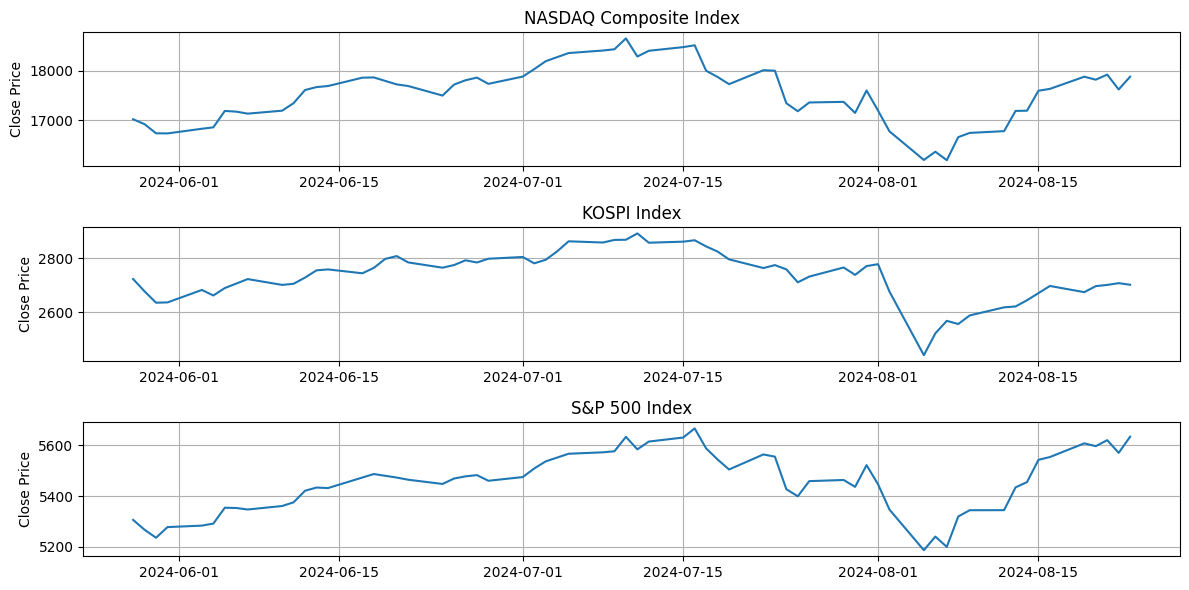

In [5]:
# Nasdaq , Kospi, Snp 500인덱스 추이 비교

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(nasdaq_data.index, nasdaq_data['Close'])
plt.title('NASDAQ Composite Index')
plt.ylabel('Close Price')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(kospi_data.index, kospi_data['Close'])
plt.title('KOSPI Index')
plt.ylabel('Close Price')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(snp_data.index, snp_data['Close'])
plt.title('S&P 500 Index')
plt.ylabel('Close Price')
plt.grid(True)

plt.tight_layout()
plt.show()


## **낙폭이 큰 기간이 있음을 확인**

In [6]:
# 나스닥 데이터에서 최고점과 최저점 찾기
high_price = nasdaq_data['Close'].max()
low_price = nasdaq_data['Close'].min()

# 최고점과 최저점의 날짜 찾기
high_date = nasdaq_data['Close'].idxmax()
low_date = nasdaq_data['Close'].idxmin()

# 날짜 기간 계산
duration = low_date - high_date

# 하락률 계산
decline_rate = ((high_price - low_price) / high_price) * 100

print(f"나스닥 최고점: {high_price} ({high_date.date()})")
print(f"나스닥 최저점: {low_price} ({low_date.date()})")
print(f"기간: {duration.days}일")
print(f"하락률: {decline_rate:.2f}%")


나스닥 최고점: 18647.44921875 (2024-07-10)
나스닥 최저점: 16195.8095703125 (2024-08-07)
기간: 28일
하락률: 13.15%


# 데이터

In [2]:
df_STK_DD_IFO= pd.read_csv('./STK_DD_IFO.csv')
df_STK_DD_IFO.head()

,bse_dt,tck_iem_cd,tot_hld_act_cnt,tot_hld_qty,tco_avg_hld_qty,tco_avg_hld_wht_rt,tco_avg_eal_pls,tco_avg_phs_uit_pr,tco_avg_pft_rt,tco_avg_hld_te_dd_cnt,...,dist_hnk_pct50_nmv,dist_hnk_pct70_nmv,dist_hnk_pct90_nmv,bse_end_pr,lss_ivo_rt,pft_ivo_rt,ifw_act_cnt,ofw_act_cnt,vw_tgt_cnt,rgs_tgt_cnt
0,20240730,AAL,2705,313122,115.76,14.86,-491381.62,20809.67,-22.75,1.0,...,20812.0,23336.400,25598.071,14414.531,0.9811,0.0189,5,4,655,6
1,20240711,AAL,2717,304962,112.24,14.38,-389528.74,20895.44,-18.34,1.0,...,20853.0,23338.000,25598.533,15449.399,0.9382,0.0611,5,11,1353,12
2,20240710,AAL,2721,303099,111.39,14.53,-421285.00,20907.40,-19.93,1.0,...,20873.0,23336.400,25598.533,15189.803,0.9662,0.0338,6,12,619,14
3,20240610,AAL,2761,277875,100.64,14.72,-377206.65,21030.96,-19.25,3.0,...,20978.0,23349.318,25608.000,15719.313,0.9377,0.0623,27,6,406,0
4,20240529,AAL,2615,227029,86.82,15.32,-182141.06,21412.94,-10.30,1.0,...,21418.0,23506.000,25680.509,18271.678,0.8172,0.1816,6,21,2100,15


In [3]:
df_STK_IEM_IFO = pd.read_csv('./STK_IEM_IFO.csv', encoding='cp949')
df_STK_IEM_IFO.head()

,tck_iem_cd,fc_sec_krl_nm,fc_sec_eng_nm,stk_etf_dit_cd,ltg_tot_stk_qty,fc_mkt_dit_cd,co_adr,web_adr,btp_cfc_nm,ceo_nm,eng_utk_otl_cts,ser_cfc_nm,ids_nm,mkt_pr_tot_amt
0,AA,알코아 ...,Alcoa Corp ...,주식,258340140,NYSE,"201 Isabella Street, Suite 500 PITTSBURGH PA...",https://www.alcoa.com/global/en/home,Aluminum (NEC),William Oplinger,Alcoa Corporation is a vertically integrated a...,Basic Materials,Aluminum,8928.24
1,AAL,아메리칸 에어라인스 그룹 ...,American Airline ...,주식,656703913,NASD,1 Skyview Drive FORT WORTH TX 76155 United S...,https://americanairlines.gcs-web.com/,Regional Airlines,Robert Isom,American Airlines Group Inc. is a holding comp...,Industrials,Airlines,6711.51
2,AAN,Aaron's Company ...,Aaron's Company ...,주식,31550767,NYSE,"400 Galleria Parkway Se, Suite 300 ATLANTA G...",https://investor.aarons.com/,Consumer Leasing,Stephen Olsen,"The Aaron?? Company, Inc. is a technology-enab...",Industrials,Rental & Leasing Services,318.03
3,AAOI,어플라이드 옵토일렉트로닉스 ...,AOI ...,주식,42644441,NASD,13139 Jess Pirtle Blvd SUGAR LAND TX 77478 U...,https://ao-inc.com/,Electronic Components,Chih-Hsiang Lin,"Applied Optoelectronics, Inc. is a vertically ...",Technology,Communication Equipment,393.42
4,AAON,에이에이온 ...,AAON ...,주식,81013148,NASD,2425 South Yukon Ave. TULSA OK 74107 United ...,https://www.aaon.com/,"Heating, Ventilation & Air Conditioning",Matt Tobolski,"AAON, Inc. is a producer of heating, ventilati...",Industrials,Building Products & Equipment,7605.92


In [4]:
df_CUS_TP_IFO = pd.read_csv('./CUS_TP_IFO.csv')
df_CUS_TP_IFO.head()

,bse_dt,tck_iem_cd,cus_cgr_llf_cd,cus_cgr_mlf_cd,cus_cgr_act_cnt_rt,cus_cgr_ivs_rt
0,20240826,AAL,2,22,37.2608,37.5675
1,20240826,AAL,2,25,4.8405,11.8565
2,20240826,AAL,2,21,21.4259,11.5923
3,20240826,AAL,2,23,23.9400,21.7531
4,20240816,AAL,2,21,21.4740,11.7051


In [5]:
df_STK_DT_QUT = pd.read_csv('./STK_DT_QUT.csv')
df_STK_DT_QUT.head()

,bse_dt,tck_iem_cd,iem_ong_pr,iem_hi_pr,iem_low_pr,iem_end_pr,bf_dd_cmp_ind_pr,bf_dd_cmp_ind_rt,acl_trd_qty,trd_cst,sll_cns_sum_qty,byn_cns_sum_qty,sby_bse_xcg_rt
0,20240722,AAL,10.49,10.740,10.35,10.69,0.11,1.04,38895463.0,414252965.0,0.0,0.0,1386.6
1,20240603,AAL,11.60,11.945,11.50,11.53,0.03,0.26,52899042.0,609925954.0,27221369.0,25722473.0,1381.6
2,20240531,AAL,11.51,11.570,11.25,11.50,0.06,0.52,60868405.0,699986658.0,28279620.0,32588785.0,1376.5
3,20240625,AAL,11.18,11.365,11.12,11.13,-0.03,-0.27,28547274.0,317731160.0,17399022.0,11148252.0,1389.7
4,20240605,AAL,11.51,11.765,11.45,11.62,0.12,1.04,34340914.0,399041421.0,17637074.0,16703939.0,1373.1


In [6]:
# 티커 공백 지우기
df_STK_DD_IFO['tck_iem_cd'] = df_STK_DD_IFO['tck_iem_cd'].astype(str).str.upper().str.strip()
df_STK_IEM_IFO['tck_iem_cd'] = df_STK_IEM_IFO['tck_iem_cd'].astype(str).str.upper().str.strip()
df_CUS_TP_IFO['tck_iem_cd'] = df_CUS_TP_IFO['tck_iem_cd'].astype(str).str.upper().str.strip()
df_STK_DT_QUT['tck_iem_cd'] = df_STK_DT_QUT['tck_iem_cd'].astype(str).str.upper().str.strip()


# 나이대별 투자동향 분석

In [7]:
# 나이대로 표기 변환
df_CUS_TP_IFO['cus_cgr_mlf_cd'] = df_CUS_TP_IFO['cus_cgr_mlf_cd'].replace({
    21: 'under 29',
    22: '30-39',
    23: '40-49',
    24: '50-59',
    25: 'over 60'
})

# df_NH_CONTEST_NHDATA_STK_DD_IFO에서 최고점(20240710)기준 데이터 추출
df_stk_dd = df_STK_DD_IFO[df_STK_DD_IFO['bse_dt'] == 20240710]
df_stk_dd = df_stk_dd[['tck_iem_cd', 'tot_hld_act_cnt', 'tot_hld_qty', 'bse_end_pr']]

# 종목별 보유 수량과 기준 종가를 곱하면 총 보유 금액 도출가능
df_stk_dd['tot_value'] = df_stk_dd['tot_hld_qty'] * df_stk_dd['bse_end_pr']

# df_NH_CONTEST_NHDATA_CUS_TP_IFO에서 cus_cgr_llf_cd가 2인 데이터만 추출합니다.
df_cus_tp = df_CUS_TP_IFO[(df_CUS_TP_IFO['bse_dt'] == 20240710) & (df_CUS_TP_IFO['cus_cgr_llf_cd'] == 2)].copy()

# 두 데이터프레임을 tck_iem_cd(티커)를 기준으로 병합.
df_merged = pd.merge(df_cus_tp, df_stk_dd, on='tck_iem_cd', how='left')

# 종목별 나이대 비율과 보유 계좌수를 알면 나이대별 계좌수를 알 수 있다.
df_merged['총 계좌수'] =df_merged['tot_hld_act_cnt'] * df_merged['cus_cgr_act_cnt_rt']
# 종목별 나이대 비율과 종목 보유금액을 알면 나이대별 총 보유금액을 알 수 있다.
df_merged['총 보유 금액'] = df_merged['tot_value'] * df_merged['cus_cgr_act_cnt_rt']

# 나이대별 총 계좌수를 계산.
total_accounts_by_cus_cgr_mlf_cd = df_merged.groupby('cus_cgr_mlf_cd')[['총 계좌수', '총 보유 금액']].sum()

total_accounts_by_cus_cgr_mlf_cd.index.name = '나이대'
age_order = ['under 29', '30-39', '40-49', '50-59', 'over 60']
total_accounts_by_cus_cgr_mlf_cd = total_accounts_by_cus_cgr_mlf_cd.reindex(age_order)

# 종목수를 나눠주어 종복별로 나이대별 평균 계좌 수를 구한다.
total_accounts_by_cus_cgr_mlf_cd['평균 보유 계좌 수'] = total_accounts_by_cus_cgr_mlf_cd['총 계좌수'] / df_NH_CONTEST_NHDATA_CUS_TP_IFO['tck_iem_cd'].nunique()

total_accounts_by_cus_cgr_mlf_cd


,총 계좌수,총 보유 금액,평균 보유 계좌 수
나이대,,,
under 29,2.607796e+07,1.820124e+14,10037.706898
30-39,4.221347e+07,2.734286e+14,16248.448061
40-49,2.916691e+07,1.818285e+14,11226.678147
50-59,1.705629e+07,1.153867e+14,6565.161379
over 60,7.004275e+06,5.169727e+13,2696.025794


In [8]:
# 나이대별 평균 보유 계좌수 확인
fig = px.bar(
    total_accounts_by_cus_cgr_mlf_cd['평균 보유 계좌 수'].reset_index(),
    x="나이대",
    y="평균 보유 계좌 수",
    title="나이대별 총 평균 보유 미국 주식(ETF)수",
    labels={"cus_cgr_mlf_cd": "고객 분류 코드", "평균 보유 주식 수": "평균 보유 주식 수"},
    color_discrete_sequence=["#1f77b4"]
)

fig.show()


In [9]:
# 나이대별 총 보유 금액 확인
fig = px.bar(
    total_accounts_by_cus_cgr_mlf_cd['총 보유 금액'].reset_index(),
    x="나이대",
    y="총 보유 금액",
    title="나이대별 총 보유 금액",
    labels={"cus_cgr_mlf_cd": "고객 분류 코드", "총 보유 금액": "총 보유 금액"}
)

fig.show()

**인구 수에 따른 정규화 필요**

In [10]:
# 외부데이터
df_population = pd.read_excel('/연령대별 인구수.xlsx')
df_population.head()

,Unnamed: 0,0 - 4세,5 - 9세,10 - 14세,15 - 19세,20 - 24세,25 - 29세,30 - 34세,35 - 39세,40 - 44세,...,60 - 64세,65 - 69세,70 - 74세,75 - 79세,80세이상,80 - 84세,85 - 89세,90 - 94세,95 - 99세,100세 이상
0,계,1296661,1914933,2273651,2272843,2838789,3533643,3615767,3297256,4023556,...,4211091,3509250,2322783,1723662,2382540,1322888,737630,258561,56005,7456


In [11]:
# 나이대별 인구 정리
df_population.drop(columns=['Unnamed: 0'], inplace=True)

# 29세 이하 및 60세 이상의 나이는 범위가 넓기 때문에 조정 필요
# 경제활동 가능나이 15세 부터
df_population['under 29'] = df_population.loc[:, '15 - 19세':'25 - 29세'].sum(axis=1)
df_population['30-39'] = df_population['30 - 34세'] + df_population['35 - 39세']
df_population['40-49'] = df_population['40 - 44세'] + df_population['45 - 49세']
df_population['50-59'] = df_population['50 - 54세'] + df_population['55 - 59세']
# '인구구조와 직․간접 주식투자 간 관계 분석: 노년세대를 중심으로' 논문 근거
df_population['over 60'] = df_population.loc[:, '60 - 64세':'70 - 74세'].sum(axis=1)

df_population = df_population[['under 29', '30-39', '40-49', '50-59', 'over 60']]
df_population.head()

,under 29,30-39,40-49,50-59,over 60
0,8645275,6913023,7852297,8705899,10043124


In [12]:
# 데이터 병합
total_accounts_by_cus_cgr_mlf_cd['인구 수'] = df_population.iloc[0].values
total_accounts_by_cus_cgr_mlf_cd

,총 계좌수,총 보유 금액,평균 보유 계좌 수,인구 수
나이대,,,,
under 29,2.607796e+07,1.820124e+14,10037.706898,8645275
30-39,4.221347e+07,2.734286e+14,16248.448061,6913023
40-49,2.916691e+07,1.818285e+14,11226.678147,7852297
50-59,1.705629e+07,1.153867e+14,6565.161379,8705899
over 60,7.004275e+06,5.169727e+13,2696.025794,10043124


In [13]:
# 나이대별 총 계좌수, 총 보유 금액 정규화
total_accounts_by_cus_cgr_mlf_cd['인당 보유 주식 비율'] = total_accounts_by_cus_cgr_mlf_cd['평균 보유 계좌 수'] / total_accounts_by_cus_cgr_mlf_cd['인구 수']
total_accounts_by_cus_cgr_mlf_cd['인당 보유 금액 비율'] = total_accounts_by_cus_cgr_mlf_cd['총 보유 금액'] / total_accounts_by_cus_cgr_mlf_cd['인구 수']
total_accounts_by_cus_cgr_mlf_cd.head()

,총 계좌수,총 보유 금액,평균 보유 계좌 수,인구 수,인당 보유 주식 비율,인당 보유 금액 비율
나이대,,,,,,
under 29,2.607796e+07,1.820124e+14,10037.706898,8645275,0.001161,2.105340e+07
30-39,4.221347e+07,2.734286e+14,16248.448061,6913023,0.002350,3.955268e+07
40-49,2.916691e+07,1.818285e+14,11226.678147,7852297,0.001430,2.315609e+07
50-59,1.705629e+07,1.153867e+14,6565.161379,8705899,0.000754,1.325385e+07
over 60,7.004275e+06,5.169727e+13,2696.025794,10043124,0.000268,5.147529e+06


In [14]:
# 나이대별 인당 보유 주식 비율 확인
fig = px.bar(
    total_accounts_by_cus_cgr_mlf_cd['인당 보유 주식 비율'].reset_index(),
    x="나이대",
    y="인당 보유 주식 비율",
    title="나이대별 인당 보유 주식 비율",
    labels={"cus_cgr_mlf_cd": "고객 분류 코드", "인당 보유 주식 비율": "인당 보유 주식 비율"},
    color_discrete_sequence=["#1f77b4"]
)

fig.show()

**나이대별 인당 미국 주식 및 ETF 보유 비율을 시각화한 결과, 50대 이상의 투자자들은 다른 나이대에 비해 미국 주식을 상대적으로 덜 보유하고 있는 것으로 나타났다. 특히 60대 이상의 투자자는 30대와 비교하여 보유 비율이 10배 이상 차이가 났으며, 이는 30대가 평균적으로 10개의 미국 주식 종목에 투자하고 있다면, 60대는 1개의 종목에만 투자하고 있음을 의미한다.**

In [15]:
# 나이대별 계좌수 확인
fig = px.bar(
    total_accounts_by_cus_cgr_mlf_cd['인당 보유 금액 비율'].reset_index(),
    x="나이대",
    y="인당 보유 금액 비율",
    title="나이대별 인당 보유 금액 비율",
    labels={"cus_cgr_mlf_cd": "고객 분류 코드", "인당 보유 금액 비율": "인당 보유 금액 비율"}
)

fig.show()

**비록 투자한 종목의 수가 적더라도 투자 금액은 많을 수 있다. 그러나 시각화 결과에 따르면, 나이대별 인당 미국 주식 및 ETF 보유 금액 비율에서도 50대 이상의 투자자가 다른 나이대에 비해 적은 금액을 보유하고 있는 것으로 확인됐다. 이는 종목 수뿐만 아니라 투자 금액 면에서도 차이가 있음을 시사한다.**

# 나이대별 구성비율이 높은 종목 추출 후 분석

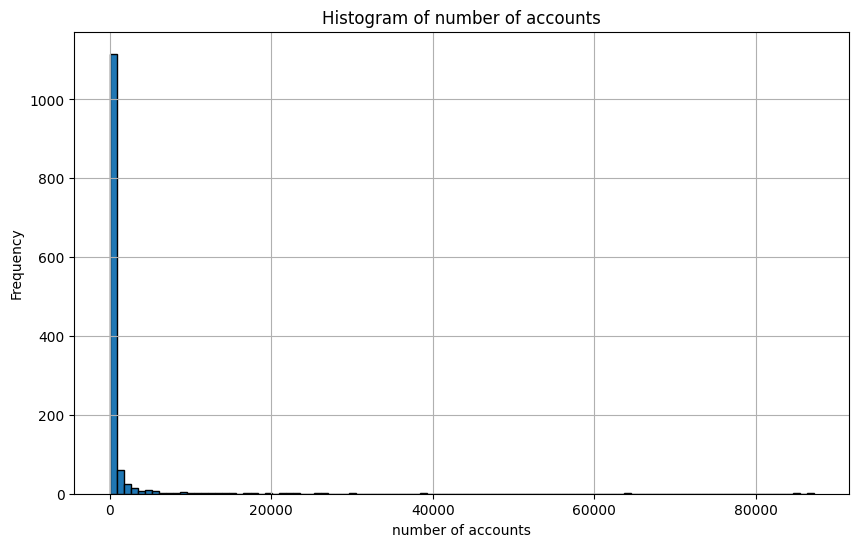

In [17]:
# 하락 시작일인 2024년 7월 10일 기준으로 분석
df_filtered = df_STK_DD_IFO[df_STK_DD_IFO['bse_dt'] == 20240710]

# 종목별 보유 계좌 수 분포 확인
plt.figure(figsize=(10, 6))
plt.hist(df_filtered['tot_hld_act_cnt'], bins=100, edgecolor='black')
plt.xlabel('number of accounts')
plt.ylabel('Frequency')
plt.title('Histogram of number of accounts')
plt.grid(True)
plt.show()


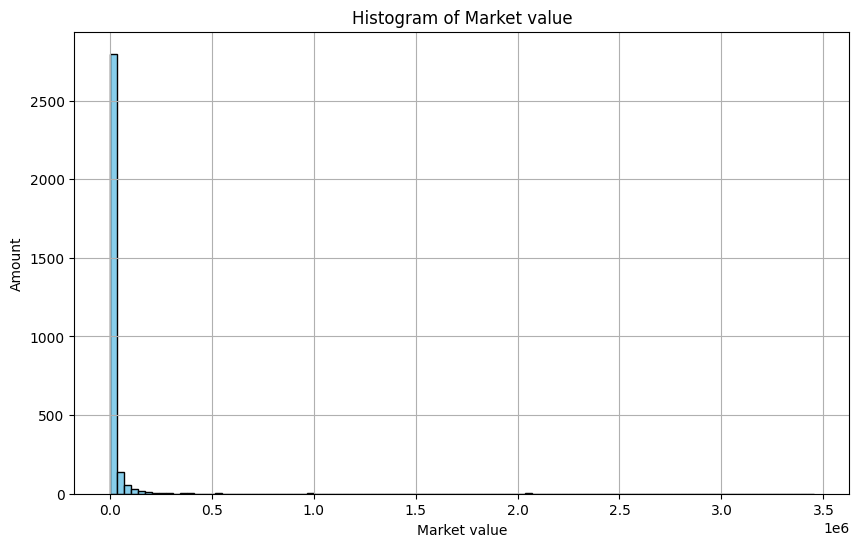

In [18]:
# 종목별 시가총액 분포 확인
plt.figure(figsize=(10, 6))
plt.hist(df_STK_IEM_IFO['mkt_pr_tot_amt'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Market value')
plt.ylabel('Amount')
plt.title('Histogram of Market value')
plt.grid(True)
plt.show()

**종목별 보유 계좌수와 시가총액이 적은 종목이 많은 것을 확인(Right skewness)**

In [19]:
# 편향된 분석을 피하기 위해 보유 계좌수와 시가총액의 median 값 이상인 종목만 선정하여 분석 진행
df_filtered_cnt = df_STK_DD_IFO[df_STK_DD_IFO['tot_hld_act_cnt'] >= df_STK_DD_IFO['tot_hld_act_cnt'].median()]
df_filtered_mk = df_STK_IEM_IFO[df_STK_IEM_IFO['mkt_pr_tot_amt']>=df_STK_IEM_IFO['mkt_pr_tot_amt'].median()]

# 데이터 필터링
df_filtered_cus = df_CUS_TP_IFO[(df_CUS_TP_IFO['bse_dt'] == 20240710) & (df_CUS_TP_IFO['tck_iem_cd'].isin(df_filtered_cnt['tck_iem_cd']))]
df_filtered_cus = df_filtered_cus[df_filtered_cus['tck_iem_cd'].isin(df_filtered_mk['tck_iem_cd'])]

# 종목별 나이대별 비율 추출
df_filtered = df_filtered_cus[df_filtered_cus['cus_cgr_llf_cd']==2]
df_filtered = df_filtered[df_filtered['tck_iem_cd'].isin(df_filtered_cnt['tck_iem_cd'])]

df_filtered.head()

,bse_dt,tck_iem_cd,cus_cgr_llf_cd,cus_cgr_mlf_cd,cus_cgr_act_cnt_rt,cus_cgr_ivs_rt
456,20240710,AAL,2,40-49,23.5208,18.5972
457,20240710,AAL,2,under 29,21.7567,12.1469
458,20240710,AAL,2,over 60,4.4836,11.3903
459,20240710,AAL,2,50-59,12.6057,17.7137
460,20240710,AAL,2,30-39,37.6332,40.1519


In [20]:
# 연령대별 상위 10개의 주식 종목을 저장할 딕셔너리 초기화
top_10_by_cus_cgr_mlf_cd = {}

# 각 연령대별 고객 그룹 코드를 순회
for cus_cgr_mlf_cd in df_filtered['cus_cgr_mlf_cd'].unique():
    # 현재 연령대 고객 그룹에 해당하는 데이터 필터링
    df_temp = df_filtered[df_filtered['cus_cgr_mlf_cd'] == cus_cgr_mlf_cd]

    # 'cus_cgr_act_cnt_rt' 기준으로 상위 10개의 종목을 선택하고, 해당 종목의 티커 코드('tck_iem_cd') 리스트 추출
    top_10 = df_temp.nlargest(10, 'cus_cgr_act_cnt_rt')['tck_iem_cd'].tolist()

    # 연령대별 상위 10개 종목을 딕셔너리에 저장
    top_10_by_cus_cgr_mlf_cd[cus_cgr_mlf_cd] = top_10

# 딕셔너리를 DataFrame으로 변환
# 각 열은 연령대를 나타내며, 해당 연령대의 상위 10개 주식 종목을 포함
top_10_df = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in top_10_by_cus_cgr_mlf_cd.items()]))

# 선택한 연령대('under 29', '30-39', '40-49', '50-59', 'over 60')의 데이터를 출력
top_10_df[['under 29', '30-39', '40-49', '50-59', 'over 60']]

,under 29,30-39,40-49,50-59,over 60
0,MNST,NE,SWK,PGR,CZR
1,LSXMK,MAR,UBS,AMGN,AMGN
2,TTWO,BK,EW,CCJ,MSTR
3,LSXMA,SWKS,LUMN,NTLA,MCHP
4,AVAV,OVV,WU,MSTR,MSCI
5,BL,PR,SCCO,GT,SMCI
6,PEP,LOGI,PENN,AA,AVGO
7,NDAQ,PAYO,AVB,HOOD,DT
8,EXPE,PINS,DRI,UBS,MU
9,DPZ,ADMA,GLPI,VKTX,CVNA


## 추출된 종목 시가총액 분포 시각화

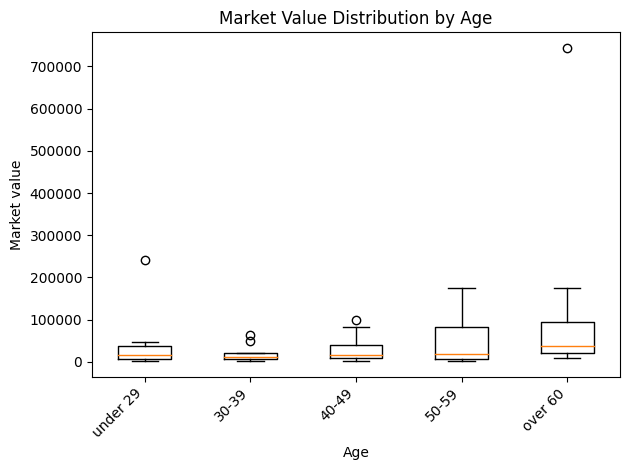

In [22]:
# 추출된 종목 시가총액 분포 시각화
positions = ['under 29', '30-39', '40-49', '50-59', 'over 60']
mkt_pr_tot_amts = [] # Initialize mkt_pr_tot_amts outside the loop

for i, age in enumerate(positions):  # Use enumerate to get index
  temp_amts = []
  for tck_iem_cd in top_10_by_cus_cgr_mlf_cd[age_order[i]]:  # Access values using age_order
    try:
      temp_df = df_STK_IEM_IFO[df_STK_IEM_IFO['tck_iem_cd'] == tck_iem_cd]
      if not temp_df.empty:
        temp_amts.extend(temp_df['mkt_pr_tot_amt'].tolist())
    except:
      pass
  mkt_pr_tot_amts.append(temp_amts)  # Append the list for each age group


plt.boxplot(mkt_pr_tot_amts, positions=range(1, len(positions) + 1), labels=positions, widths=0.5)  # Use range for positions


plt.xlabel('Age')
plt.ylabel('Market value')
plt.title('Market Value Distribution by Age')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**나이대가 높은 투자자들이 많이 투자한 종목은 시가총액이 높은 경향이 있다.**

## 추출된 종목의 베타 시각화

In [23]:
# 추출된 종목별로 nasdaq_data의 Date가 2024-05-28 ~ 2024-07-10(최고점)동안 beta값이 어떻게 되는지 연령대별 분석

beta_results = {}

for cus_cgr_mlf_cd, tck_iem_cds in top_10_by_cus_cgr_mlf_cd.items():
  for tck_iem_cd in tck_iem_cds:
      temp_df_stock = df_STK_DT_QUT[
          (df_STK_DT_QUT['tck_iem_cd'] == tck_iem_cd) &
          (df_STK_DT_QUT['bse_dt'] >= 20240528) &
          (df_STK_DT_QUT['bse_dt'] <= 20240710)
      ]
      temp_df_stock.sort_values(by='bse_dt', inplace=True)

      if not temp_df_stock.empty:
        # 나스닥 데이터와 주식 데이터의 날짜를 맞춤.
        nasdaq_data_filtered = nasdaq_data[
            (nasdaq_data.index >= pd.Timestamp(2024, 5, 28)) & # use Timestamp, correct date range
            (nasdaq_data.index <= pd.Timestamp(2024, 7, 10))]

        # 주식 데이터와 나스닥 데이터의 수익률을 계산.
        stock_returns = temp_df_stock['iem_end_pr'].pct_change().dropna()
        nasdaq_returns = nasdaq_data_filtered['Close'].pct_change().dropna()

        # 선형 회귀를 수행하여 베타를 계산.
        slope, intercept, r_value, p_value, std_err = linregress(nasdaq_returns, stock_returns)

        # 결과 저장
        if tck_iem_cd not in beta_results:
          beta_results[tck_iem_cd] = {}
        beta_results[tck_iem_cd][cus_cgr_mlf_cd] = slope


# 결과 출력
# for tck_iem_cd, cus_cgr_mlf_cd_betas in beta_results.items():
#   print(f"tck_iem_cd: {tck_iem_cd}")
#   for cus_cgr_mlf_cd, beta in cus_cgr_mlf_cd_betas.items():
#     print(f"  cus_cgr_mlf_cd: {cus_cgr_mlf_cd}, Beta: {beta:.4f}")
#   print("\n")


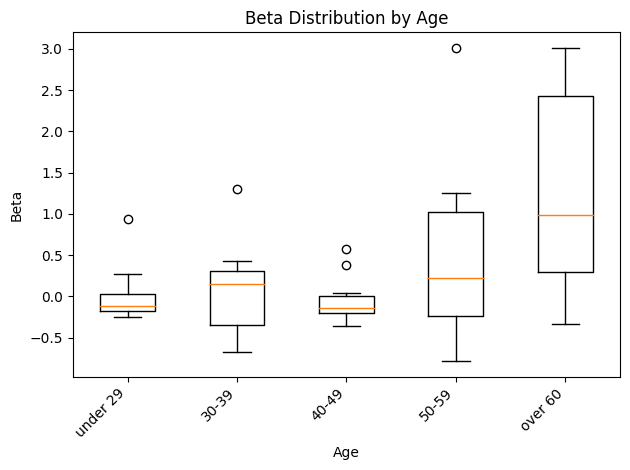

In [33]:
# 추출된 종목(나이대별 투자비중이 높은 종목들)의 베타 시각화

beta_by_cus_cgr_mlf_cd = {}
for tck_iem_cd, cus_cgr_mlf_cd_betas in beta_results.items():
  for cus_cgr_mlf_cd, beta in cus_cgr_mlf_cd_betas.items():
    if cus_cgr_mlf_cd not in beta_by_cus_cgr_mlf_cd:
      beta_by_cus_cgr_mlf_cd[cus_cgr_mlf_cd] = []
    beta_by_cus_cgr_mlf_cd[cus_cgr_mlf_cd].append(beta)

# Create a dictionary to map age group strings to numerical positions
age_to_position = {age: i for i, age in enumerate(positions)}

for cus_cgr_mlf_cd, betas in beta_by_cus_cgr_mlf_cd.items():
    # Use the age_to_position dictionary to get the numerical position
    position = age_to_position.get(cus_cgr_mlf_cd)
    if position is not None:
        plt.boxplot(betas, positions=[position], labels=[cus_cgr_mlf_cd], widths=0.5)

plt.xlabel('Age')
plt.ylabel('Beta')
plt.title('Beta Distribution by Age')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**나이대가 높은 투자자들의 투자비중이 높은 종목의 베타가 양수로 높은 경향이 있다.**

**이는 시장의 움직이는 방향과 비슷한 움직임을 가지는 종목의 투자가 많다는 것의 의미한다.**

## 추출종목 급락 동안의 수익률 확인

In [34]:
# top_10_by_cus_cgr_mlf_cdd에서 tck_iem_cdd(티커) 추출 후 df_NH_CONTEST_STK_DT_QUT에서 20240710 ~2024807사이의 수익률을 계산.

# top_10_by_cus_cgr_mlf_cd에서 tck_iem_cd 추출
all_tck_iem_cd = []
for cus_cgr_mlf_cd, top_10_list in top_10_by_cus_cgr_mlf_cd.items():
  all_tck_iem_cd.extend(top_10_list)

# 중복 제거
all_tck_iem_cd = list(set(all_tck_iem_cd))

# df_NH_CONTEST_STK_DT_QUT에서 해당 종목들의 20240710 ~ 20240807 사이의 수익률 계산
avg_return_by_cus_cgr_mlf_cd = {}
for cus_cgr_mlf_cd, top_10_list in top_10_by_cus_cgr_mlf_cd.items():
  total_return_for_cus_cgr_mlf_cd = 0
  count_for_cus_cgr_mlf_cd = 0
  for tck_iem_cd in top_10_list:
    df_temp = df_STK_DT_QUT[(df_STK_DT_QUT['tck_iem_cd'] == tck_iem_cd)]
    start_price = df_temp[df_temp['bse_dt'] == 20240710]['iem_end_pr'].iloc[0]
    end_price = df_temp[df_temp['bse_dt'] == 20240807]['iem_end_pr'].iloc[0]
    return_rate = (end_price - start_price) / start_price
    print(f"종목 코드: {tck_iem_cd}, 고객 분류 코드: {cus_cgr_mlf_cd}, 수익률: {return_rate:.2%}")
    total_return_for_cus_cgr_mlf_cd += return_rate
    count_for_cus_cgr_mlf_cd += 1
  if count_for_cus_cgr_mlf_cd > 0:
    avg_return_for_cus_cgr_mlf_cd = total_return_for_cus_cgr_mlf_cd / count_for_cus_cgr_mlf_cd
    avg_return_by_cus_cgr_mlf_cd[cus_cgr_mlf_cd] = avg_return_for_cus_cgr_mlf_cd

# 결과출력
print("\연령별 상위 종목의 평균 수익률:")
# 나이대별 종목의 평균 수익률 계산
for cus_cgr_mlf_cd, avg_return in avg_return_by_cus_cgr_mlf_cd.items():
  print(f"고객 분류 코드: {cus_cgr_mlf_cd}, 평균 수익률: {avg_return:.2%}")


종목 코드: SWK, 고객 분류 코드: 40-49, 수익률: 12.02%
종목 코드: UBS, 고객 분류 코드: 40-49, 수익률: -8.39%
종목 코드: EW, 고객 분류 코드: 40-49, 수익률: -34.88%
종목 코드: LUMN, 고객 분류 코드: 40-49, 수익률: 531.43%
종목 코드: WU, 고객 분류 코드: 40-49, 수익률: -7.43%
종목 코드: SCCO, 고객 분류 코드: 40-49, 수익률: -16.59%
종목 코드: PENN, 고객 분류 코드: 40-49, 수익률: -14.00%
종목 코드: AVB, 고객 분류 코드: 40-49, 수익률: 2.05%
종목 코드: DRI, 고객 분류 코드: 40-49, 수익률: 2.75%
종목 코드: GLPI, 고객 분류 코드: 40-49, 수익률: 8.84%
종목 코드: MNST, 고객 분류 코드: under 29, 수익률: 1.36%
종목 코드: LSXMK, 고객 분류 코드: under 29, 수익률: -7.44%
종목 코드: TTWO, 고객 분류 코드: under 29, 수익률: -8.84%
종목 코드: LSXMA, 고객 분류 코드: under 29, 수익률: -7.41%
종목 코드: AVAV, 고객 분류 코드: under 29, 수익률: -4.80%
종목 코드: BL, 고객 분류 코드: under 29, 수익률: 4.56%
종목 코드: PEP, 고객 분류 코드: under 29, 수익률: 5.01%
종목 코드: NDAQ, 고객 분류 코드: under 29, 수익률: 8.39%
종목 코드: EXPE, 고객 분류 코드: under 29, 수익률: -12.58%
종목 코드: DPZ, 고객 분류 코드: under 29, 수익률: -10.55%
종목 코드: CZR, 고객 분류 코드: over 60, 수익률: -4.45%
종목 코드: AMGN, 고객 분류 코드: over 60, 수익률: -2.85%
종목 코드: MSTR, 고객 분류 코드: over 60, 수익률: -90.45%
종목 코드: MC

## 수익률 분포확인

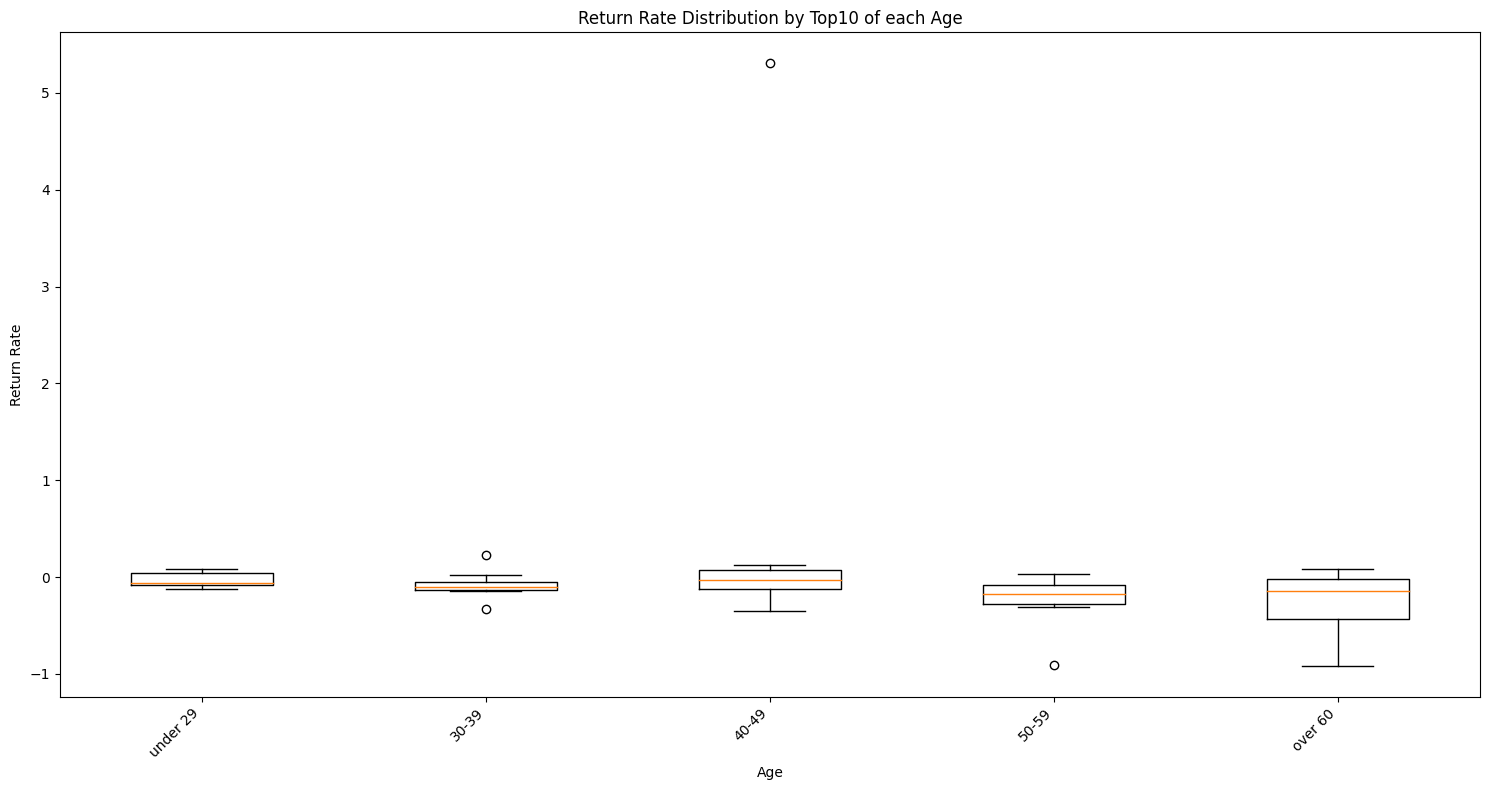

In [35]:
# 수익률 분포 확인

return_data_by_cus_cgr_mlf_cd = {}
for cus_cgr_mlf_cd, top_10_list in top_10_by_cus_cgr_mlf_cd.items():
  return_rates = []
  for tck_iem_cd in top_10_list:
    df_temp = df_STK_DT_QUT[(df_STK_DT_QUT['tck_iem_cd'] == tck_iem_cd)]
    if not df_temp.empty:
      start_price = df_temp[df_temp['bse_dt'] == 20240710]['iem_end_pr'].iloc[0]
      end_price = df_temp[df_temp['bse_dt'] == 20240807]['iem_end_pr'].iloc[0]
      return_rate = (end_price - start_price) / start_price
      return_rates.append(return_rate)
  return_data_by_cus_cgr_mlf_cd[cus_cgr_mlf_cd] = return_rates

age_to_position = {age: i for i, age in enumerate(positions)}

plt.figure(figsize=(15, 8))

for cus_cgr_mlf_cd, return_rates in return_data_by_cus_cgr_mlf_cd.items():
    # Use the age_to_position dictionary to get the numerical position
    position = age_to_position.get(cus_cgr_mlf_cd)
    if position is not None:
        plt.boxplot(return_rates, positions=[position], labels=[cus_cgr_mlf_cd], widths=0.5)

plt.xlabel('Age')
plt.ylabel('Return Rate')
plt.title('Return Rate Distribution by Top10 of each Age')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


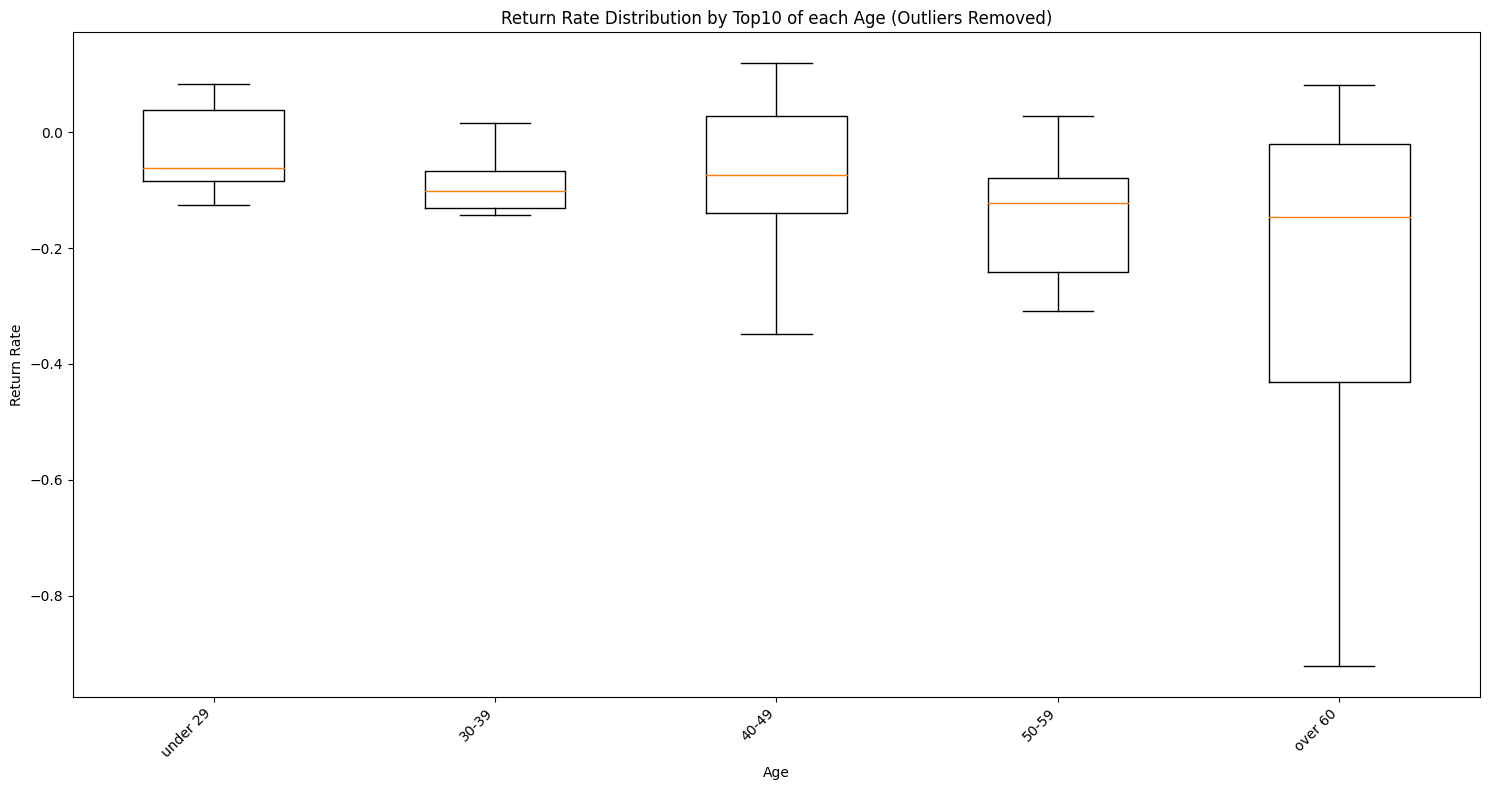

In [36]:
# 위의 그래프에서 outlier제외한 시각화

plt.figure(figsize=(15, 8))

ordered_keys = ['under 29', '30-39', '40-49', '50-59', 'over 60']

age_to_position = {age: i for i, age in enumerate(ordered_keys)}

for cus_cgr_mlf_cd, return_rates in return_data_by_cus_cgr_mlf_cd.items():
  # 아웃라이어 제거 (IQR 기반)
  if return_rates:
    Q1 = np.percentile(return_rates, 25)
    Q3 = np.percentile(return_rates, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return_rates_no_outliers = [x for x in return_rates if lower_bound <= x <= upper_bound]

    position = age_to_position[cus_cgr_mlf_cd]  # Get position from dictionary
    plt.boxplot(return_rates_no_outliers, positions=[position], labels=[cus_cgr_mlf_cd], widths=0.5)

plt.xlabel('Age')
plt.ylabel('Return Rate')
plt.title('Return Rate Distribution by Top10 of each Age (Outliers Removed)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**나이대가 높은 투자자의 비중이 높은 종목의 손실이 큰 것을 확인**

---------------------------------------------------------------------------------------------------------------------

# 데이터분석을 통한 인사이트
#### 1. 50대 이상의 투자자의 미국 주식 및 ETF 투자활동이 활발하지 않다.
#### 2. 50대 이상의 투자자의 비중이 높은 미국 종목이 시가 총액과 베타가 높고, 시장 하락 시 손실률이 크다.

### => 얻은 인사이트를 기반으로 **중장년 투자자들의 미국 주식 및 ETF 투자 참여의 촉진과 건강하고 안전한 투자를 위한 서비스를 제공**이 주제로 적합하다는 결론.




## **서비스 1 : 생성형 AI를 활용한 투자 교육 서비스**

*   건강하고 안전한 투자를 위해서는 금융경제 및 경제지표에 대한 지식이 필요하다.
*   이를 생성형 AI를 활용하여 문제를 만들고 맞출 시 리워드를 제공함으로써 참여를 촉진하고, 못 맞출 시 교육자료를 생성하여 제공하는 서비스를 구상하였다.

아래의 구현에서 리워드 기능은 없음


Streamlit을 활용한 서비스 초안

*   https://nhdacon-ajuz6edb8fduywen6eh5ad.streamlit.app



## **서비스 2 : 장년층을 고려한 맞춤형 ETF 추천**

*   연령대별, 개인별 맞춤형 ETF 추천 서비스를 제공하여 투자 참여를 촉진할 수 있다.
*   투자자의 성향과 목적을 파악하기 위한 질문을 제시하고, 생성형 AI를 활용해 이를 분석한 후, 분석된 결과를 바탕으로 ETF 배당내역과 점수 데이터를 활용해 적합한 ETF를 추천하는 서비스를 구상하였다.
* 특히 중장년층을 고려한 맞춤형 질문을 통해 이들의 투자 참여를 더욱 활성화시키는 데 초점을 맞추고 있다.

Streamlit을 활용한 서비스 초안

*   https://nhdacon-ikjkgkgbhnogkcrrautfuk.streamlit.app/

## **서비스 3 : 포트폴리오 보유한 투자자의 헷지(hedge)를 위한 ETF추천**

*   분석 결과, 50대 이상의 투자자들이 하락장에서 큰 손실을 입는 경향이 있음을 확인했다.
*   이를 근거로 생성형 AI를 활용하여 투자자의 성향을 분석하고 맞춤형 헷지 전략을 수립한 뒤, ETF 점수 데이터를 기반으로 적합한 ETF를 추천하는 서비스를 구상했다.
* 이 서비스는 시장 하락 시 투자자들이 얼마나 손실을 방어할 수 있을지를 시각적으로 제공함으로써, 투자 참여를 촉진하는 것을 목표로 한다.

Streamlit을 활용한 서비스 초안

*   https://nhdacon-hhn4m3bkushshuitzwmoau.streamlit.app

### 서비스 구현 코드
* https://github.com/tjsdnqq11/NH_Dacon/tree/main